In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stat

In [3]:
df = pd.read_csv('bank.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


### one-hot encoding + random forest model

In [5]:
categorical = [var for var in df.columns if df[var].dtype =='object']
print('categorical:',categorical)

numeric = [var for var in df.columns if df[var].dtype == 'int64']
print('numeric:',numeric)

categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
numeric: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [6]:
for var in categorical:
     print(df[var].value_counts()/np.float(len(df)))

management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: job, dtype: float64
married     0.568984
single      0.315176
divorced    0.115839
Name: marital, dtype: float64
secondary    0.490593
tertiary     0.330496
primary      0.134385
unknown      0.044526
Name: education, dtype: float64
no     0.984949
yes    0.015051
Name: default, dtype: float64
no     0.526877
yes    0.473123
Name: housing, dtype: float64
no     0.869199
yes    0.130801
Name: loan, dtype: float64
cellular     0.720480
unknown      0.210177
telephone    0.069342
Name: contact, dtype: float64
may    0.253001
aug    0.136087
jul    0.135639
jun    0.109479
nov    0.084483
apr    0.082691
feb    0.069522
oct    0.035119
jan    0.030819
sep    0.028579
mar    0.0

<ipython-input-6-31f3815c72d6>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(df[var].value_counts()/np.float(len(df)))


In [7]:
for var in categorical:
    print(var, 'contains', df[var].unique())

job contains ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital contains ['married' 'single' 'divorced']
education contains ['secondary' 'tertiary' 'primary' 'unknown']
default contains ['no' 'yes']
housing contains ['yes' 'no']
loan contains ['no' 'yes']
contact contains ['unknown' 'cellular' 'telephone']
month contains ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome contains ['unknown' 'other' 'failure' 'success']
deposit contains ['yes' 'no']


education, contact, poutcome 변수에 있는 unknown 값을 NaN으로 대체 한 후 각 데이터의 최빈값으로 대체

In [8]:
df['education'].replace('unknown', np.NAN, inplace=True)
df['contact'].replace('unknown', np.NAN, inplace=True)
df['poutcome'].replace('unknown', np.nan, inplace=True)

In [9]:
df.isnull().sum()

age             0
job             0
marital         0
education     497
default         0
balance         0
housing         0
loan            0
contact      2346
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     8326
deposit         0
dtype: int64

In [10]:
for var in categorical:
    df[var].fillna(df[var].mode()[0], inplace=True)

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,-1,0,failure,yes
1,56,admin.,married,secondary,no,45,no,no,cellular,5,may,1467,1,-1,0,failure,yes
2,41,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,-1,0,failure,yes
3,55,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,-1,0,failure,yes
4,54,admin.,married,tertiary,no,184,no,no,cellular,5,may,673,2,-1,0,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,failure,no
11158,39,services,married,secondary,no,733,no,no,cellular,16,jun,83,4,-1,0,failure,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,failure,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [11]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [12]:
# deposit는 목표변수 이므로 train 데이터에서 쓰이지 않으므로 미리 categorical에서 제거해줌

categorical.remove('deposit')

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


8929

In [14]:
# 정확도를 높이기 위해 범주형 변수들을 원-핫 인코딩처리

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

categorical_column = categorical
encoder = OneHotEncoder(drop='first', sparse=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_column])
X_test_encoded = encoder.fit_transform(X_test[categorical_column])

X_train_encoded_rf = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(categorical_column), index=X_train.index)
X_test_encoded_rf = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names(categorical_column), index=X_test.index)

In [15]:
X_train_encoded_rf

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
3955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11150,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2910,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_test_encoded_rf

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
5527,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4541,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
X_train_new = pd.concat([X_train[numeric], X_train_encoded_rf], axis=1)

X_test_new = pd.concat([X_test[numeric], X_test_encoded_rf], axis=1)

In [18]:
X_train_new

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
3955,28,5741,10,1042,5,200,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11150,34,355,21,314,3,-1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5173,48,201,10,594,1,91,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3017,53,1961,15,351,1,-1,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2910,53,1624,11,166,3,97,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,47,761,11,80,2,-1,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,28,159,16,449,2,33,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5390,35,1144,20,197,13,-1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,51,746,25,372,5,-1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_new[numeric] = scaler.fit_transform(X_train[numeric])
X_test_new[numeric] = scaler.transform(X_test[numeric])



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_new, y_train)

y_pred = clf.predict(X_test_new)

print('Test accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Test accuracy score with 10 decision-trees : 0.8316


In [25]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
confusion_matrix=confusion_matrix(y_test,y_pred)
confusion_matrix

array([[941, 225],
       [151, 916]], dtype=int64)

In [26]:
print(clf.feature_importances_)

[0.08455167 0.0878883  0.07340265 0.35461506 0.03781464 0.04258066
 0.029556   0.00858875 0.00315628 0.0028011  0.00886939 0.00485442
 0.00419212 0.00578532 0.00513178 0.00923141 0.00370629 0.00136074
 0.01133863 0.00988212 0.01045129 0.01027005 0.0013676  0.02835303
 0.01044797 0.0065734  0.01033196 0.0021639  0.00854155 0.00497407
 0.00895901 0.00831476 0.01478303 0.01686109 0.0078038  0.01204542
 0.00825203 0.00355025 0.03664845]


In [28]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train_new.columns)
feat_importances

age                    0.084552
balance                0.087888
day                    0.073403
duration               0.354615
campaign               0.037815
pdays                  0.042581
previous               0.029556
job_blue-collar        0.008589
job_entrepreneur       0.003156
job_housemaid          0.002801
job_management         0.008869
job_retired            0.004854
job_self-employed      0.004192
job_services           0.005785
job_student            0.005132
job_technician         0.009231
job_unemployed         0.003706
job_unknown            0.001361
marital_married        0.011339
marital_single         0.009882
education_secondary    0.010451
education_tertiary     0.010270
default_yes            0.001368
housing_yes            0.028353
loan_yes               0.010448
contact_telephone      0.006573
month_aug              0.010332
month_dec              0.002164
month_feb              0.008542
month_jan              0.004974
month_jul              0.008959
month_ju

In [29]:
feat_importances = feat_importances.sort_values()
feat_importances

job_unknown            0.001361
default_yes            0.001368
month_dec              0.002164
job_housemaid          0.002801
job_entrepreneur       0.003156
poutcome_other         0.003550
job_unemployed         0.003706
job_self-employed      0.004192
job_retired            0.004854
month_jan              0.004974
job_student            0.005132
job_services           0.005785
contact_telephone      0.006573
month_nov              0.007804
month_sep              0.008252
month_jun              0.008315
month_feb              0.008542
job_blue-collar        0.008589
job_management         0.008869
month_jul              0.008959
job_technician         0.009231
marital_single         0.009882
education_tertiary     0.010270
month_aug              0.010332
loan_yes               0.010448
education_secondary    0.010451
marital_married        0.011339
month_oct              0.012045
month_mar              0.014783
month_may              0.016861
housing_yes            0.028353
previous

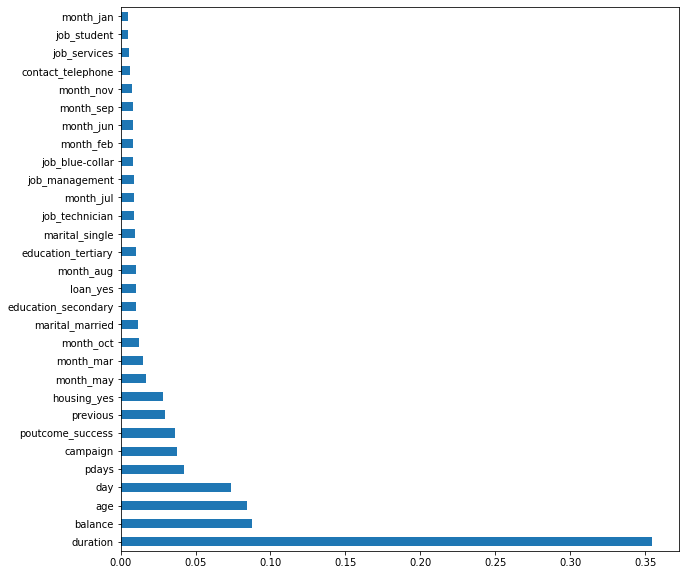

In [30]:
plt.figure(figsize=(10,10))
feat_importances.nlargest(30).plot(kind='barh')
plt.show()